In [19]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,datetime,time,math,itertools,os,sys

import torch
import torch.nn as nn
from torch.nn import functional as F

import tensorflow as tf

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout,BatchNormalization,Concatenate,Input
from tensorflow.keras.regularizers import l2,l1

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.model_selection import train_test_split

import pandas as pd

import snowflake.connector

import seaborn as sns

In [2]:
def unpack_timeseries(D,in_seq_len,out_seq_len=1):
    # Determine feature dimension and make 2nd dimension, so that time dimension is leading
    if len(D.shape)==1:
        n_features = 1
    else:
        n_features = D.shape[0]
    D = D.reshape(-1,n_features)
    # Containers for result
    X,Y = [],[]
    # Iterate through data in defined steps
    for k in range(in_seq_len,D.shape[0]-out_seq_len+1):
        X.append(D[k-in_seq_len:k,:])
        Y.append(D[k:k+out_seq_len,:])
    # Make numpy arrays
    X = np.array(X)
    Y = np.array(Y)
    # Return results
    return X,Y

In [3]:
conn = snowflake.connector.connect(
    user='jan-lucas.deinhard@siemens-healthineers.com',
    account='shsitdl.west-europe.azure',
    authenticator='externalbrowser'
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [4]:
info = pd.read_sql("SHOW COLUMNS",con=conn)

In [5]:
query = '''
SELECT 
     acc."Account Name (MainAccount)"||'||'||acc."Account Country" AS "Key"
    ,olis."OLI.Close Date"
    ,SUM(olis."Funnel Value (GC)") as "Funnel Value (GC)"
FROM "CRMCL_TOPICAREA"."OSC"."Accounts" acc
LEFT JOIN "CRMCL_TOPICAREA"."OSC"."OLIs" olis ON acc."ACCOUNT_ID"=olis."ACCOUNT_ID"
WHERE acc."CKAP (Flag)"='Y'
AND olis."OLI.Close Date">TO_DATE('01-01-2012','DD-MM-YYYY')
AND olis."OLI.Close Date"<TO_DATE('01-01-2022','DD-MM-YYYY')
GROUP BY
"Key"
,olis."OLI.Close Date"
ORDER BY "Key",olis."OLI.Close Date" ASC
'''

df = pd.read_sql(query,con=conn)

In [6]:
conn.close()

In [7]:
df['OLI.Close Date'] = pd.to_datetime(df['OLI.Close Date'])

In [8]:
df['Account Country'] = df['Key'].str.rsplit('||',n=2,expand=True)[1]

<AxesSubplot:xlabel='OLI.Close Date'>

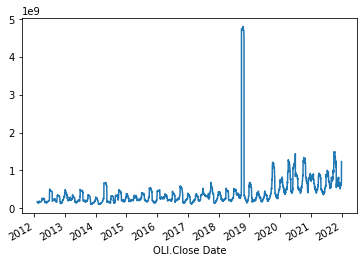

In [9]:
df0 = df.pivot(index='OLI.Close Date',columns=['Key'],values=['Funnel Value (GC)']).fillna(0)
df0.columns = df0.columns.droplevel(-2)

df0.apply(lambda x: x.sum(),axis=1).rolling(30).sum().plot()

In [10]:
df1 = df0.transpose()

In [11]:
pca = PCA(n_components=2)
pca_red_ts = pca.fit_transform(df1.values)

df1['2D PCA Comp0'] = pca_red_ts[:,0]
df1['2D PCA Comp1'] = pca_red_ts[:,1]

In [12]:
include_thresholds = [0.1,0.9]

df1['Outliers'] = 'Y'
df1['Outliers'][(df1['2D PCA Comp0']<df1['2D PCA Comp0'].quantile(include_thresholds[1]))&(df1['2D PCA Comp0']>df1['2D PCA Comp0'].quantile(include_thresholds[0]))] = 'N'

<ipython-input-12-fa1fdf3d8204>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Outliers'][(df1['2D PCA Comp0']<df1['2D PCA Comp0'].quantile(include_thresholds[1]))&(df1['2D PCA Comp0']>df1['2D PCA Comp0'].quantile(include_thresholds[0]))] = 'N'


In [13]:
ms = MeanShift()

ms.fit(df1[df1['Outliers']=='N'][['2D PCA Comp0','2D PCA Comp1']].values)
df1['MeanShift Predicted Class'] = ms.predict(df1[['2D PCA Comp0','2D PCA Comp1']].values)

[]

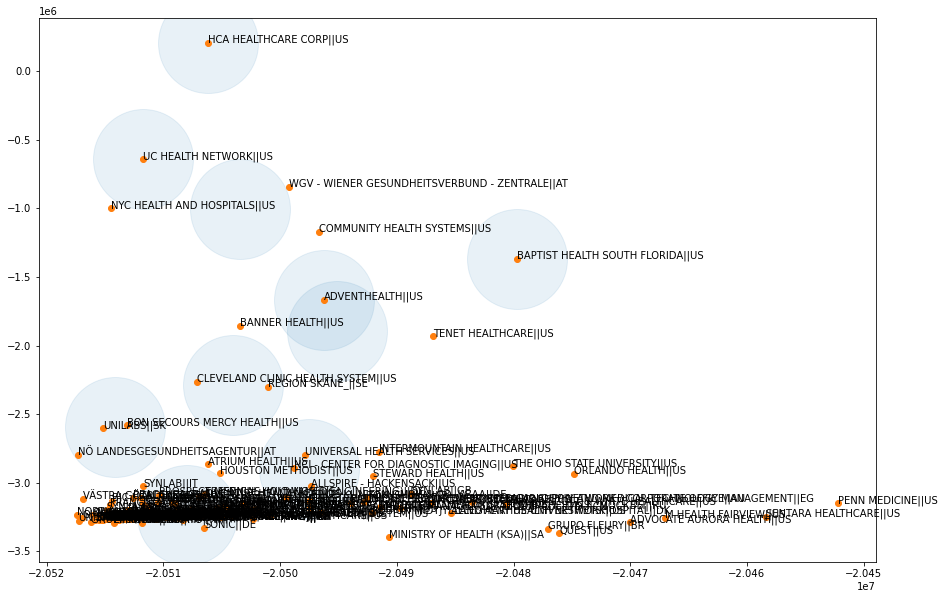

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.subplots()

ax.scatter(ms.cluster_centers_[:,0],ms.cluster_centers_[:,1],s=10000,alpha=0.1)
ax.scatter(df1[df1['Outliers']=='N'][['2D PCA Comp0','2D PCA Comp1']].values[:,0],df1[df1['Outliers']=='N'][['2D PCA Comp0','2D PCA Comp1']].values[:,1])

for L in df1[df1['Outliers']=='N'][['2D PCA Comp0','2D PCA Comp1']].reset_index(drop=False).values:
    ax.annotate(L[0],(L[1],L[2]))

plt.plot()

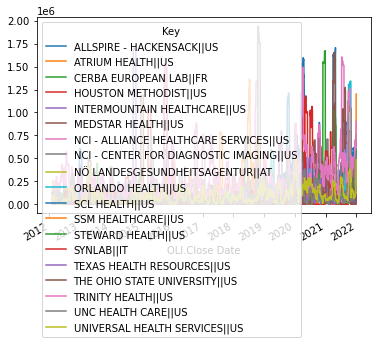

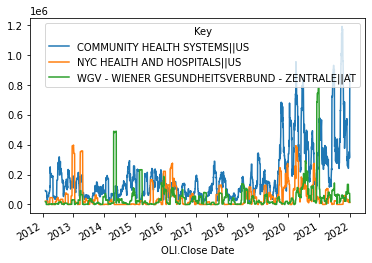

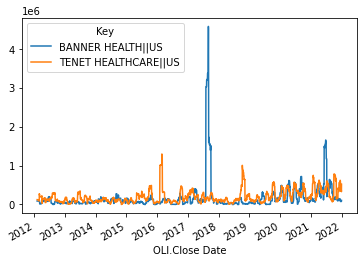

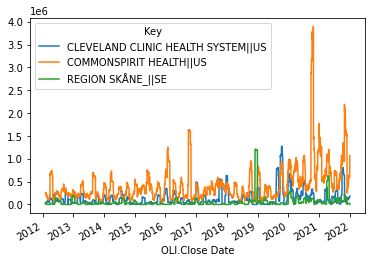

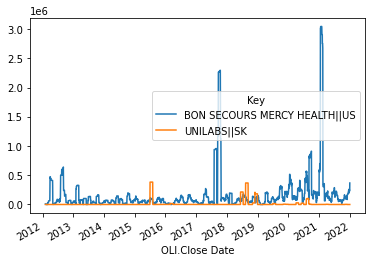

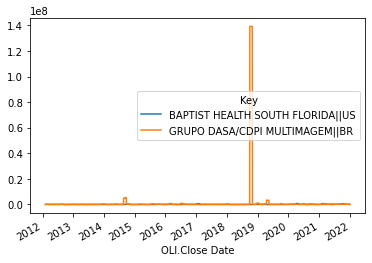

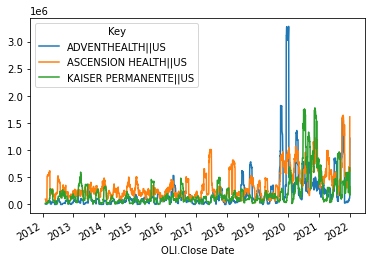

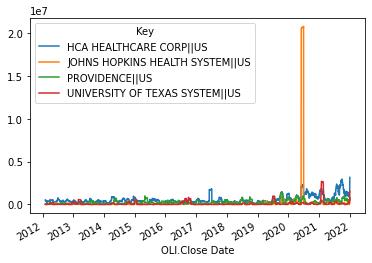

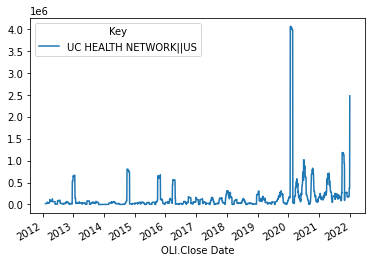

In [15]:
for cclass in np.unique(ms.labels_):
    if cclass==0: continue
    df0[df1[df1['MeanShift Predicted Class']==cclass].index].rolling(30).mean().plot()
    plt.show()

In [16]:
# Data containers
X = np.empty(shape=[0,20,1])
Y = np.empty(shape=[0,1,1])

# Iterate through all data
for ccol in df0.columns:
    # Select one particular timeseries
    c_data = df0[ccol].rolling(30).mean().dropna().values
    XX,YY = unpack_timeseries(c_data,in_seq_len=20,out_seq_len=1)
    # Append to total data set
    X = np.append(X,XX,axis=0)
    Y = np.append(Y,YY,axis=0)

In [17]:
# Split into training and test sets 
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size=0.15)

In [18]:
# Scale data
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain.reshape(-1,20)).reshape(-1,20,1)
Xtest = scaler.transform(Xtest.reshape(-1,20)).reshape(-1,20,1)

In [20]:
in0 = Input(shape=(X.shape[1],X.shape[2],))
x = LSTM(units=15,activation='relu',return_sequences=True,activity_regularizer=l2(1e-2))(in0)
x = Dropout(rate=0.5)(x)
x = LSTM(units=10,activation='relu',activity_regularizer=l1(5e-2))(x)
x = Dense(units=5,activation='relu',activity_regularizer=l1(5e-2))(x)
x = Dropout(rate=0.5)(x)
out0 = Dense(units=1,activation='relu',activity_regularizer=l1(5e-1))(x)

model = Model(inputs=in0,outputs=out0)

model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [21]:
model.fit(Xtrain,Ytrain,epochs=100,batch_size=128,validation_split=0.1,verbose=1)

Epoch 1/100
4205/4205 [==============================] - 41s 9ms/step - loss: 1225637590129.9402 - mse: 1225637467160.3462 - val_loss: 553308979200.0000 - val_mse: 553308979200.0000
Epoch 2/100
4205/4205 [==============================] - 36s 8ms/step - loss: 1091349335979.2753 - mse: 1091349335744.0913 - val_loss: 532135641088.0000 - val_mse: 532135641088.0000
Epoch 3/100
4205/4205 [==============================] - 37s 9ms/step - loss: 777782161330.0923 - mse: 777782109016.0114 - val_loss: 508886810624.0000 - val_mse: 508886745088.0000
Epoch 4/100
4205/4205 [==============================] - 36s 9ms/step - loss: 1335302302943.9849 - mse: 1335302273496.3157 - val_loss: 557030309888.0000 - val_mse: 557030309888.0000
Epoch 5/100
4205/4205 [==============================] - 37s 9ms/step - loss: 821885046378.1493 - mse: 821884985522.2140 - val_loss: 709758812160.0000 - val_mse: 709758812160.0000
Epoch 6/100
4205/4205 [==============================] - 35s 8ms/step - loss: 1317967535358.17

4205/4205 [==============================] - 35s 8ms/step - loss: 636422693191.9430 - mse: 635355457885.1241 - val_loss: 825996410880.0000 - val_mse: 819555336192.0000
Epoch 47/100
4205/4205 [==============================] - 33s 8ms/step - loss: 857801974055.0756 - mse: 850344550902.5050 - val_loss: 1845119025152.0000 - val_mse: 1839820701696.0000
Epoch 48/100
4205/4205 [==============================] - 34s 8ms/step - loss: 993229214892.8578 - mse: 988496429038.2273 - val_loss: 607967248384.0000 - val_mse: 600876580864.0000
Epoch 49/100
4205/4205 [==============================] - 33s 8ms/step - loss: 632666000047.2925 - mse: 626455056036.4584 - val_loss: 538223902720.0000 - val_mse: 529548115968.0000
Epoch 50/100
4205/4205 [==============================] - 33s 8ms/step - loss: 772395384754.0923 - mse: 764042159605.7747 - val_loss: 607634653184.0000 - val_mse: 600867405824.0000
Epoch 51/100
4205/4205 [==============================] - 33s 8ms/step - loss: 1075994873712.8445 - mse: 1

4205/4205 [==============================] - 32s 8ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 100/100
4205/4205 [==============================] - 32s 8ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan


In [523]:
outlier_thresholds = [0.1,0.9]

ef = pd.DataFrame()

ef['True Label'] = Ytest.reshape(-1)
ef['Predicted Label'] = model.predict(Xtest).reshape(-1)

ef['Outlier'] = 'N'

tl_thresholds = [ef['True Label'].quantile(outlier_thresholds[0]),ef['True Label'].quantile(outlier_thresholds[1])]
pl_thresholds = [ef['Predicted Label'].quantile(outlier_thresholds[0]),ef['Predicted Label'].quantile(outlier_thresholds[1])]

# True Label Outliers
ef.at[ef[(ef['True Label']<tl_thresholds[0])|(ef['True Label']>tl_thresholds[1])].index,'Outlier'] = 'Y'
# Predicted Label Outliers
ef.at[ef[(ef['Predicted Label']<pl_thresholds[0])|(ef['Predicted Label']>pl_thresholds[1])].index,'Outlier'] = 'Y'

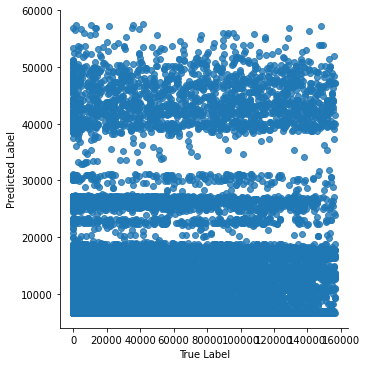

In [519]:
sns.lmplot(x='True Label',y='Predicted Label',data=ef[ef['Outlier']=='N'],fit_reg=False)

In [524]:
ef

,True Label,Predicted Label,Outlier
0,473458.333702,NaN,Y
1,44454.258613,NaN,N
2,0.000000,NaN,N
3,0.000000,NaN,N
4,73520.522673,NaN,N
...,...,...,...
105591,80233.941253,NaN,N
105592,80087.029617,NaN,N
105593,281600.561462,NaN,Y
105594,878536.808257,NaN,Y
